<a href="https://colab.research.google.com/github/pabloknappo/hello-world/blob/main/spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
#check the tensorflow version and available devices
print("Tensorflow version: " + tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Tensorflow version: 2.7.0
GPU is available


In [3]:
! git clone https://github.com/pabloknappo/spectrogram_learning/

Cloning into 'spectrogram_learning'...
remote: Enumerating objects: 11375, done.
remote: Counting objects: 100% (1808/1808), done.
remote: Compressing objects: 100% (1806/1806), done.
remote: Total 11375 (delta 2), reused 1808 (delta 2), pack-reused 9567
Receiving objects: 100% (11375/11375), 2.22 GiB | 26.60 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (11355/11355), done.


In [4]:
! ls

drive  sample_data  spectrogram_learning


In [5]:
#get to the directory with images
path = os.path.join(os.getcwd(),'spectrogram_learning','data')

In [6]:
#change current directory
os.chdir('/content')

In [7]:
print(path)
! ls

/content/spectrogram_learning/data
drive  sample_data  spectrogram_learning


In [59]:
data_dir = path

#image format data
IMG_HEIGHT = 160
IMG_WIDTH = 160
IMG_SIZE = (160, 160)

#set batch size
BATCH_SIZE = 64


In [60]:

#create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='training',
  labels='inferred',
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 1799 files belonging to 3 classes.
Using 1440 files for training.


In [61]:
#create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  labels='inferred',
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 1799 files belonging to 3 classes.
Using 359 files for validation.


In [62]:
class_names = train_ds.class_names

num_classes = len(class_names)

print(class_names)

['inner race fault', 'no fault', 'outter race fault']


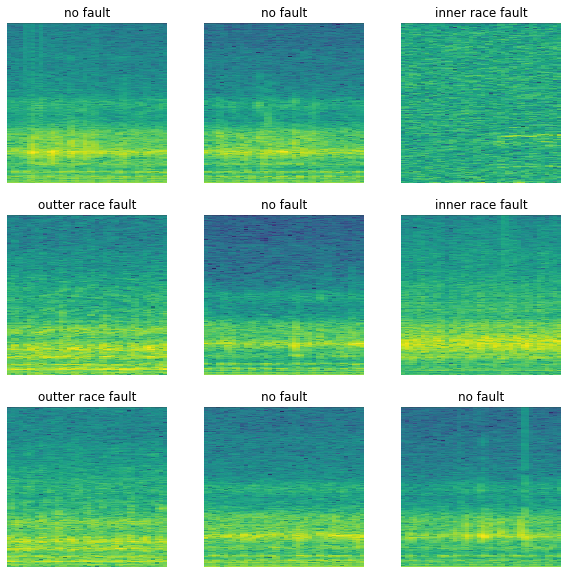

In [63]:
#visualize the data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [64]:
#create a test dataset as a 1/5 part of validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [65]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 5
Number of test batches: 1


In [66]:
#

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [67]:
#rescale expected values from [0,255] to [-1,1]

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [68]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,) #???????????
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [69]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1280)


In [70]:
#freeeze conv layers
base_model.trainable = False

In [71]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_7[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [72]:
#add classification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [73]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 3)


In [74]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer(x)
outputs = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs, outputs)

In [75]:
base_learning_rate = 0.0001
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

#if you don't use probabilistic output
#model.compile(
#  optimizer='adam',
#  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
#  metrics=['accuracy'])


In [76]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [77]:
len(model.trainable_variables)

2

In [78]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(val_ds)

5/5 [==============================] - 4s 106ms/step - loss: 1.5881 - accuracy: 0.2102


In [79]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.59
initial accuracy: 0.21


In [80]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/5
23/23 [==============================] - 15s 382ms/step - loss: 0.9388 - accuracy: 0.5701 - val_loss: 0.3840 - val_accuracy: 0.9729
Epoch 2/5
23/23 [==============================] - 12s 393ms/step - loss: 0.3067 - accuracy: 0.9500 - val_loss: 0.1652 - val_accuracy: 1.0000
Epoch 3/5
23/23 [==============================] - 12s 387ms/step - loss: 0.1632 - accuracy: 0.9840 - val_loss: 0.0960 - val_accuracy: 1.0000
Epoch 4/5
23/23 [==============================] - 12s 384ms/step - loss: 0.1160 - accuracy: 0.9882 - val_loss: 0.0669 - val_accuracy: 1.0000
Epoch 5/5
23/23 [==============================] - 14s 478ms/step - loss: 0.0859 - accuracy: 0.9944 - val_loss: 0.0524 - val_accuracy: 1.0000


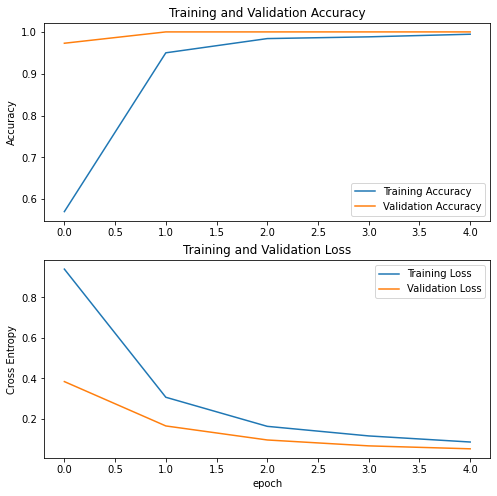

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [82]:
#fine tuning
base_model.trainable = True

In [83]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [84]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [85]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [86]:
len(model.trainable_variables)

56

In [87]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 5/10
23/23 [==============================] - 19s 460ms/step - loss: 0.5768 - accuracy: 0.9792 - val_loss: 0.5525 - val_accuracy: 1.0000
Epoch 6/10
23/23 [==============================] - 13s 439ms/step - loss: 0.5634 - accuracy: 0.9903 - val_loss: 0.5523 - val_accuracy: 1.0000
Epoch 7/10
23/23 [==============================] - 13s 424ms/step - loss: 0.5548 - accuracy: 0.9972 - val_loss: 0.5519 - val_accuracy: 1.0000
Epoch 8/10
23/23 [==============================] - 13s 443ms/step - loss: 0.5641 - accuracy: 0.9882 - val_loss: 0.5517 - val_accuracy: 1.0000
Epoch 9/10
23/23 [==============================] - 13s 422ms/step - loss: 0.5544 - accuracy: 0.9972 - val_loss: 0.5521 - val_accuracy: 1.0000
Epoch 10/10
23/23 [==============================] - 12s 419ms/step - loss: 0.5544 - accuracy: 0.9972 - val_loss: 0.5518 - val_accuracy: 1.0000


In [88]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

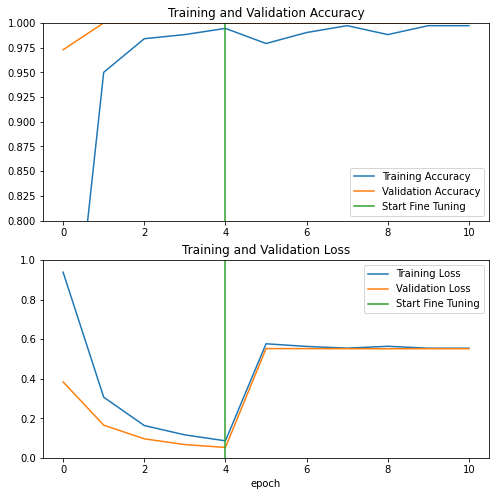

In [89]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [90]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

1/1 [==============================] - 2s 2s/step - loss: 0.5515 - accuracy: 1.0000
Test accuracy : 1.0


In [91]:
import pandas as pd


image_batch, label_batch = test_ds.as_numpy_iterator().next()
#true_label_ids = np.argmax(label_batch, axis=-1)
print('Image batch shape: ', image_batch.shape)
predictions = model.predict_on_batch(image_batch)
#predictions = tf.nn.sigmoid(predictions)
print('Prediction results shape:', predictions.shape)

# Convert prediction results to Pandas dataframe, for better visualization
tf_pred_dataframe = pd.DataFrame(predictions)
tf_pred_dataframe.columns = class_names

Image batch shape:  (64, 160, 160, 3)
Prediction results shape: (64, 3)


In [92]:
tf_pred_dataframe.head()

,inner race fault,no fault,outter race fault
0,9.999990e-01,8.152884e-07,6.105427e-08
1,3.933099e-05,9.999559e-01,4.779989e-06
2,2.974608e-08,9.912115e-05,9.999008e-01
3,9.999994e-01,4.519716e-07,1.364618e-07
4,8.120012e-07,8.148322e-06,9.999911e-01


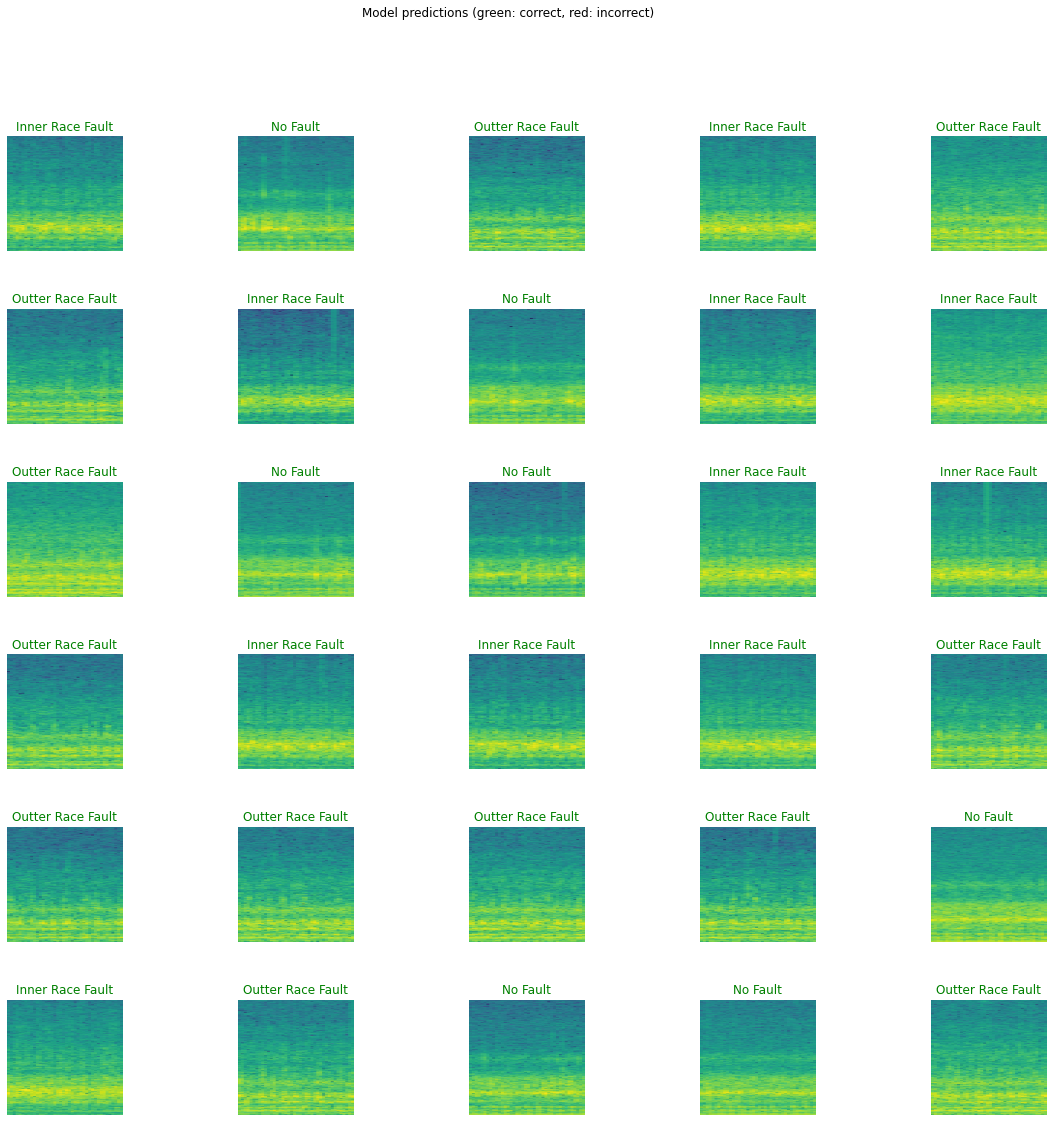

In [93]:
# Get predictions for each image
predicted_ids = np.argmax(predictions, axis=-1)
predicted_ids = np.array(predicted_ids)
predicted_ids = (list(predicted_ids))
predicted_labels = []
for idx in predicted_ids:
  predicted_labels.append(class_names[idx])


# Print images batch and labels predictions
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n]/255)
  color = "green" if predicted_ids[n] == list(label_batch)[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [94]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')
tf.saved_model.save(model,'model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: model/assets


In [95]:
#get to the directory with images
saved_model_dir = os.path.join(os.getcwd(),'model')
print(saved_model_dir)

/content/model


In [98]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model_with_softmax.tflite', 'wb') as f:
  f.write(tflite_model)

In [97]:
#create a labels file from class_names list

textfile = open("model_labels.txt", "w")
for element in class_names:
    textfile.write(element + "\n")
textfile.close()
